In [152]:
import pandas as pd
import numpy as np
import psycopg2
import datetime
import math
import matplotlib.pyplot as plt
from scipy import stats

In [153]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [154]:
df_events = pd.read_csv('~/Downloads/Lyft_events.csv')
df_installs = pd.read_csv('~/Downloads/Lyft_installs.csv')

In [155]:
df_installs['timestamp'] = pd.to_datetime(df_installs['timestamp'], unit='ms').astype('datetime64[ns, Europe/Paris]').dt.tz_convert('EST')
df_installs

referrer                                  aaid    appIdentifier  \
0            NaN  09d10511-a935-4eaa-8a96-bcf14d3a6209  me.lyft.android   
1            NaN  6f11e9d7-ff8b-44f6-bf6b-592a39ae0f3a  me.lyft.android   
2            NaN  6e5a3cad-4776-4260-9a8d-a051a4fb4808  me.lyft.android   
3            NaN  a606a6c1-d58e-4ed8-ad4f-0dcff6ca5f7e  me.lyft.android   
4            NaN  b9bfd624-b252-401b-95f0-f0afb3b53ec9  me.lyft.android   
...          ...                                   ...              ...   
1612869      NaN  c240b4a0-f0ff-4d72-a696-b75f94ebae99  me.lyft.android   
1612870      NaN  ec8f56a6-b231-4f95-b630-24c4060b83f2  me.lyft.android   
1612871      NaN  cceb9e2c-02da-49e2-9c4a-d12be80fa263  me.lyft.android   
1612872      NaN  6513dad3-a5c3-4783-b5bc-3bed81a28cf8  me.lyft.android   
1612873      NaN  e7ac04d9-b39f-4b02-a320-a37972b5b241  me.lyft.android   

                               timestamp  
0       2021-02-20 09:51:01.272000-05:00  
1       2021-02-14 10:09:29.100000-05:00  
2       2021-02-14 10:10:00.922000-05:00  
3       2021-02-16 10:06:03.120000-05:00  
4       2021-02-14 10:02:02.573000-05:00  
...                                  ...  
1612869 2021-03-10 00:29:01.730000-05:00  
1612870 2021-03-11 00:28:01.105000-05:00  
1612871 2021-03-11 00:28:01.516000-05:00  
1612872 2021-03-16 00:53:01.393000-05:00  
1612873 2021-03-11 02:45:01.476000-05:00  

[1612874 rows x 4 columns]

In [156]:
df_events['referrer'] = df_events['referrer'].replace('empty',np.nan)
df_events['date'] = df_events['date'].astype('datetime64[ns, EST]')
df_events

referrer  \
0        APPIA56931762567162129525035960764182311105   
1       APPIA247296620612646852916552562715717308598   
2                   APPIA161445965260020638214561792   
3                                                NaN   
4                                                NaN   
...                                              ...   
364731                                           NaN   
364732                                           NaN   
364733                                           NaN   
364734                                           NaN   
364735                                           NaN   

                                        aaid            appId     event  \
0       2e1c1971-0cbc-4125-a394-ad8686b81709  me.lyft.android  purchase   
1       b25adb1b-610b-487f-9251-ef866c9b33d9  me.lyft.android  purchase   
2       a87cdc94-128c-4a80-bc7e-380e5cf85316  me.lyft.android  purchase   
3       953d23e8-f505-4d2c-bf8f-06bda9134a88  me.lyft.android  purchase   
4       5051ff23-5485-4acf-b883-121e441b759d  me.lyft.android  purchase   
...                                      ...              ...       ...   
364731  f9e9627e-c57b-466b-b9bf-764ea53f091c  me.lyft.android  purchase   
364732  409b48a4-13cb-4e49-a726-6ddd13b60585  me.lyft.android  purchase   
364733  28f67dd5-9577-4d82-94e2-4b6edef2e23f  me.lyft.android  purchase   
364734  22bb8345-6d13-4757-84c4-c237f672a15f  me.lyft.android  purchase   
364735  6ea27303-56e5-4f68-b634-c6790ca2899c  me.lyft.android  purchase   

        eventVar                      date  
0            NaN 2021-02-26 15:21:42-05:00  
1            NaN 2021-02-27 22:19:32-05:00  
2            NaN 2021-02-27 21:00:16-05:00  
3            NaN 2021-02-03 19:02:17-05:00  
4            NaN 2021-02-03 19:02:17-05:00  
...          ...                       ...  
364731       NaN 2021-03-11 04:51:44-05:00  
364732       NaN 2021-03-11 04:51:41-05:00  
364733       NaN 2021-03-11 04:51:47-05:00  
364734       NaN 2021-03-11 04:52:38-05:00  
364735       NaN 2021-03-11 04:52:41-05:00  

[364736 rows x 6 columns]

In [157]:
df = pd.merge(df_installs,df_events, left_on = ['aaid','referrer'], right_on = ['aaid','referrer'], how = 'left', suffixes = ('_install', '_event'))
df = df[['referrer','aaid','appIdentifier','timestamp','date']]
df.columns = ['referrer_install','aaid','appid','timestamp_install','timestamp_event']
df.dtypes

referrer_install                  object
aaid                              object
appid                             object
timestamp_install    datetime64[ns, EST]
timestamp_event      datetime64[ns, EST]
dtype: object

In [158]:
df['tte'] = np.ceil((df['timestamp_event'] - df['timestamp_install']).dt.total_seconds()/86400.0)
by_day = df.pivot_table(values = 'aaid', index = 'tte', aggfunc = lambda x:len(np.unique(x)))
by_day['sov'] = by_day['aaid']/by_day['aaid'].sum()
by_day

aaid       sov
tte                    
-0.0      248  0.000904
 1.0   200156  0.729546
 2.0    14777  0.053860
 3.0     8581  0.031277
 4.0     6267  0.022843
 5.0     4945  0.018024
 6.0     4126  0.015039
 7.0     3756  0.013690
 8.0     3479  0.012681
 9.0     2596  0.009462
 10.0    2273  0.008285
 11.0    2028  0.007392
 12.0    1732  0.006313
 13.0    1689  0.006156
 14.0    1720  0.006269
 15.0    1581  0.005763
 16.0    1353  0.004932
 17.0    1116  0.004068
 18.0    1006  0.003667
 19.0    1014  0.003696
 20.0     901  0.003284
 21.0     936  0.003412
 22.0     875  0.003189
 23.0     755  0.002752
 24.0     648  0.002362
 25.0     596  0.002172
 26.0     591  0.002154
 27.0     574  0.002092
 28.0     573  0.002089
 29.0     508  0.001852
 30.0     468  0.001706
 31.0     376  0.001370
 32.0     309  0.001126
 33.0     281  0.001024
 34.0     254  0.000926
 35.0     219  0.000798
 36.0     222  0.000809
 37.0     203  0.000740
 38.0     153  0.000558
 39.0     124  0.000452
 40.0     101  0.000368
 41.0      84  0.000306
 42.0      82  0.000299
 43.0      49  0.000179
 44.0      24  0.000087
 45.0       8  0.000029

In [159]:
df['DT_install'] = df['referrer_install'].str.contains('APPIA', na=False)
df = df[(df['timestamp_event'] >= df['timestamp_install']) | (df['timestamp_event'].isna())]

install_start_dt = min(df.loc[(df.referrer_install.str.contains('APPIA', na=False)) 
                            & (~df.referrer_install.str.contains('APPIAOS', na=False))
                            ,'timestamp_install']).date().strftime('%Y-%m-%d')
install_end_dt = max(df.loc[df.referrer_install.str.contains('APPIA', na=False),'timestamp_install']).date().strftime('%Y-%m-%d')
print(install_start_dt, install_end_dt)

2021-02-04 2021-03-17


In [160]:
by_attribution = df.groupby('DT_install')[['timestamp_install','timestamp_event']].count()
by_attribution['event_rate'] = by_attribution['timestamp_event']/by_attribution['timestamp_install']
by_attribution

timestamp_install  timestamp_event  event_rate
DT_install                                                
False                 1580708           273979    0.173327
True                    33529              918    0.027379

In [161]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [162]:
# Get preload timestamps, classified as appselect or silent, associated notification timestamps, and classifying the 
# aaid as test (has lyft preload) or control. Filter out only the preload groups we want in df_preload_filtered
query_preload = """
    select
        aaid
        , preload_type
        , t.site_name
        , t.site_id
        , timestamp_preload
        , timestamp_notification
        , case when device_app_preloads > 0 --and (preload_type = 'AppSelect' or has_notification = 1)
            then 'test' else 'control' end as test_audience
    from
    (
        select 
            ctp.advertising_id as aaid 
            , ctp.tracking_time as timestamp_preload
            , ctc.tracking_time as timestamp_notification
            , case when android_package_name = 'me.lyft.android' then 1 else 0 end as is_app_preload
            , case when ctc.tracking_time is not null then 1 else 0 end as has_notification
            , case when site_name like '%AppSelect%' then 'AppSelect' else 'Silent' end as preload_type
            , ctp.site_id
            , max(s.site_name) as site_name
            , sum(count(case when android_package_name = 'me.lyft.android' then 1 else NULl end)) 
                over (partition by ctp.advertising_id) as device_app_preloads
        from rawdata.campaign_tracking_active_preload ctp 
        left join 
        (
            select
                advertising_id
                , max(tracking_time) as tracking_time
            from rawdata.campaign_tracking_active_click
            where android_package_name = 'me.lyft.android'
                and sti_type = 'Not Single Tap'
                and date(tracking_time) >= date('{start_dt}')
                and date(tracking_time) <= date('{end_dt}') + interval '30 day'
            group by 1
        ) ctc 
            on ctp.advertising_id = ctc.advertising_id 
            and ctc.tracking_time > ctp.tracking_time
            and ctc.tracking_time < ctp.tracking_time + interval '30 day' 
            and ctp.android_package_name = 'me.lyft.android'
        join 
        (
            select
                date(tracking_time) as preload_dt
                , site_id
            from rawdata.campaign_tracking_active_preload
                where android_package_name = 'me.lyft.android'    
                and date(tracking_time) >= date('{start_dt}')
                and date(tracking_time) <= date('{end_dt}')
            group by 1,2
        ) app
            on ctp.site_id = app.site_id
            and date(ctp.tracking_time) = app.preload_dt
        join rawdata.site s 
            on ctp.site_id = s.site_id
        where 
            date(ctp.tracking_time) >= date('{start_dt}')
            and date(ctp.tracking_time) <= date('{end_dt}')
        group by 1,2,3,4,5,6,7
    ) t
    where
        (device_app_preloads > 0 and is_app_preload = 1) --is test device, and is a test app preload
        or (device_app_preloads = 0 and is_app_preload = 0) --is control device, and is non-test-app preload
    group by 1,2,3,4,5,6,7
"""

In [163]:
df_preload_list = []
for dt in pd.date_range(start = install_start_dt, end = install_end_dt, freq = '7D'):
    start_dt = dt.strftime('%Y-%m-%d')
    end_dt = min(install_end_dt, (dt + datetime.timedelta(days = 6)).strftime('%Y-%m-%d'))
    print('Running date range',start_dt,'to',end_dt)
    cur_atlas.execute(query_preload.format(start_dt = start_dt, end_dt = end_dt))
    df_sub = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])
    df_preload_list.append(df_sub)

df_preload = pd.concat(df_preload_list)

Running date range 2021-02-04 to 2021-02-10
Running date range 2021-02-11 to 2021-02-17
Running date range 2021-02-18 to 2021-02-24
Running date range 2021-02-25 to 2021-03-03
Running date range 2021-03-04 to 2021-03-10
Running date range 2021-03-11 to 2021-03-17


In [231]:
df_preload['timestamp_preload'] = df_preload.timestamp_preload.astype('datetime64[ns, EST]')
df_preload['timestamp_notification'] = df_preload.timestamp_notification.astype('datetime64[ns, EST]')
df_preload['notification'] = ~df_preload['timestamp_notification'].isna()

filters = (df_preload.timestamp_preload.dt.date >= datetime.date(2021,2,18)) & (df_preload.timestamp_preload.dt.date <= datetime.date(2021,3,19)) #& ((df_preload.preload_type == 'AppSelect') | (df_preload.notification) | (df_preload.test_audience == 'control'))
df_preload_filtered = df_preload[filters]

In [232]:
df_merged = pd.merge(df,df_preload_filtered,left_on = 'aaid',right_on = 'aaid')

# install between 0 and 30 days since preload/notification (only keep preloads with installs)
df_merged = df_merged[(((df_merged.timestamp_install - df_merged.timestamp_notification).dt.days <= 30) 
                       | ((df_merged.timestamp_install - df_merged.timestamp_preload).dt.days <= 30))
                     & ((df_merged.timestamp_install - df_merged.timestamp_preload).astype('timedelta64[s]') >= 0)
                     & (((df_merged.timestamp_install - df_merged.timestamp_notification).astype('timedelta64[s]') >= 0)
                        | (df_merged.timestamp_notification.isna()))]

# events happening after install (99.5%) or no event for this install
df_merged = df_merged[((df_merged.timestamp_event - df_merged.timestamp_install).astype('timedelta64[s]') >= 0) 
                     | (df_merged.timestamp_event.isna())]

df_merged

referrer_install                                  aaid  \
9                   NaN  18360049-bde5-41a4-ae5b-825ada817e64   
10                  NaN  18360049-bde5-41a4-ae5b-825ada817e64   
11                  NaN  18360049-bde5-41a4-ae5b-825ada817e64   
12                  NaN  18360049-bde5-41a4-ae5b-825ada817e64   
13                  NaN  18360049-bde5-41a4-ae5b-825ada817e64   
...                 ...                                   ...   
258848              NaN  6513dad3-a5c3-4783-b5bc-3bed81a28cf8   
258849              NaN  6513dad3-a5c3-4783-b5bc-3bed81a28cf8   
258850              NaN  6513dad3-a5c3-4783-b5bc-3bed81a28cf8   
258851              NaN  6513dad3-a5c3-4783-b5bc-3bed81a28cf8   
258852              NaN  6513dad3-a5c3-4783-b5bc-3bed81a28cf8   

                  appid                timestamp_install timestamp_event  tte  \
9       me.lyft.android 2021-02-21 17:36:01.376000-05:00             NaT  NaN   
10      me.lyft.android 2021-02-21 17:36:01.376000-05:00             NaT  NaN   
11      me.lyft.android 2021-02-21 17:36:01.376000-05:00             NaT  NaN   
12      me.lyft.android 2021-02-21 17:36:01.376000-05:00             NaT  NaN   
13      me.lyft.android 2021-02-21 17:36:01.376000-05:00             NaT  NaN   
...                 ...                              ...             ...  ...   
258848  me.lyft.android 2021-03-16 00:53:01.393000-05:00             NaT  NaN   
258849  me.lyft.android 2021-03-16 00:53:01.393000-05:00             NaT  NaN   
258850  me.lyft.android 2021-03-16 00:53:01.393000-05:00             NaT  NaN   
258851  me.lyft.android 2021-03-16 00:53:01.393000-05:00             NaT  NaN   
258852  me.lyft.android 2021-03-16 00:53:01.393000-05:00             NaT  NaN   

        DT_install preload_type                                  site_name  \
9            False       Silent  DT - Tracfone - Ignite - Alcatel - A507DL   
10           False       Silent  DT - Tracfone - Ignite - Alcatel - A507DL   
11           False       Silent  DT - Tracfone - Ignite - Alcatel - A507DL   
12           False       Silent  DT - Tracfone - Ignite - Alcatel - A507DL   
13           False       Silent  DT - Tracfone - Ignite - Alcatel - A507DL   
...            ...          ...                                        ...   
258848       False       Silent       DT - Tracfone - Ignite -ZTE - Z559DL   
258849       False       Silent       DT - Tracfone - Ignite -ZTE - Z559DL   
258850       False       Silent       DT - Tracfone - Ignite -ZTE - Z559DL   
258851       False       Silent       DT - Tracfone - Ignite -ZTE - Z559DL   
258852       False       Silent       DT - Tracfone - Ignite -ZTE - Z559DL   

        site_id         timestamp_preload timestamp_notification  \
9         12194 2021-02-20 17:38:32-05:00                    NaT   
10        12194 2021-02-20 17:37:56-05:00                    NaT   
11        12194 2021-02-20 17:32:11-05:00                    NaT   
12        12194 2021-02-20 17:31:20-05:00                    NaT   
13        12194 2021-02-20 17:29:43-05:00                    NaT   
...         ...                       ...                    ...   
258848    11288 2021-03-15 18:06:53-05:00                    NaT   
258849    11288 2021-03-15 18:06:00-05:00                    NaT   
258850    11288 2021-03-15 18:12:38-05:00                    NaT   
258851    11288 2021-03-15 18:18:37-05:00                    NaT   
258852    11288 2021-03-15 18:33:44-05:00                    NaT   

       test_audience  notification  
9            control         False  
10           control         False  
11           control         False  
12           control         False  
13           control         False  
...              ...           ...  
258848       control         False  
258849       control         False  
258850       control         False  
258851       control         False  
258852       control         False  

[239641 rows x 14 columns]

In [233]:
# need to pivot by device in order to count only unique installs/events
# simple "count" will double-count installs and events, but we will dedupe for unique installs/events next cell
df_by_device = df_merged.pivot_table(values = ['timestamp_install','timestamp_event', 'timestamp_notification'], index = ['test_audience','aaid'], aggfunc = 'count')
df_by_device

timestamp_event  \
test_audience aaid                                                    
control       0005cc0d-61f1-4fa8-96d7-6a252c0074cf                0   
              0009b7fc-0e3b-481b-b576-86c82e9edf9e                0   
              001afa80-c963-49a6-95db-a7cc59a1cca0               10   
              001d734b-da79-47a9-9e18-dec562da78ce                0   
              001e3f65-5b72-4acb-ab62-d5bd53ca2eea                0   
...                                                             ...   
test          fff3e18f-1750-4fd3-a949-ad3429dac63f                0   
              fff6a44f-8f8a-4f33-bbef-ba8c2478134f                0   
              fff7ecb9-c280-4cb0-b74e-b2f3bf634273                0   
              fff80237-8c0d-44d3-9a65-6b52e3a9e9af                0   
              fffd681e-a2af-4cab-b49a-06d37e75c7bd                0   

                                                    timestamp_install  \
test_audience aaid                                                      
control       0005cc0d-61f1-4fa8-96d7-6a252c0074cf                 18   
              0009b7fc-0e3b-481b-b576-86c82e9edf9e                 19   
              001afa80-c963-49a6-95db-a7cc59a1cca0                 10   
              001d734b-da79-47a9-9e18-dec562da78ce                 19   
              001e3f65-5b72-4acb-ab62-d5bd53ca2eea                 10   
...                                                               ...   
test          fff3e18f-1750-4fd3-a949-ad3429dac63f                  1   
              fff6a44f-8f8a-4f33-bbef-ba8c2478134f                  1   
              fff7ecb9-c280-4cb0-b74e-b2f3bf634273                  1   
              fff80237-8c0d-44d3-9a65-6b52e3a9e9af                  1   
              fffd681e-a2af-4cab-b49a-06d37e75c7bd                  1   

                                                    timestamp_notification  
test_audience aaid                                                          
control       0005cc0d-61f1-4fa8-96d7-6a252c0074cf                       0  
              0009b7fc-0e3b-481b-b576-86c82e9edf9e                       0  
              001afa80-c963-49a6-95db-a7cc59a1cca0                       0  
              001d734b-da79-47a9-9e18-dec562da78ce                       0  
              001e3f65-5b72-4acb-ab62-d5bd53ca2eea                       0  
...                                                                    ...  
test          fff3e18f-1750-4fd3-a949-ad3429dac63f                       0  
              fff6a44f-8f8a-4f33-bbef-ba8c2478134f                       0  
              fff7ecb9-c280-4cb0-b74e-b2f3bf634273                       0  
              fff80237-8c0d-44d3-9a65-6b52e3a9e9af                       0  
              fffd681e-a2af-4cab-b49a-06d37e75c7bd                       0  

[38440 rows x 3 columns]

In [234]:
print('Control/Test # of Unique Preloads:',df_preload_filtered.loc[df_preload_filtered.test_audience == 'control','aaid'].nunique(),df_preload_filtered.loc[df_preload_filtered.test_audience == 'test','aaid'].nunique())

Control/Test # of Unique Preloads: 903416 159924


(0.0, 0.5)

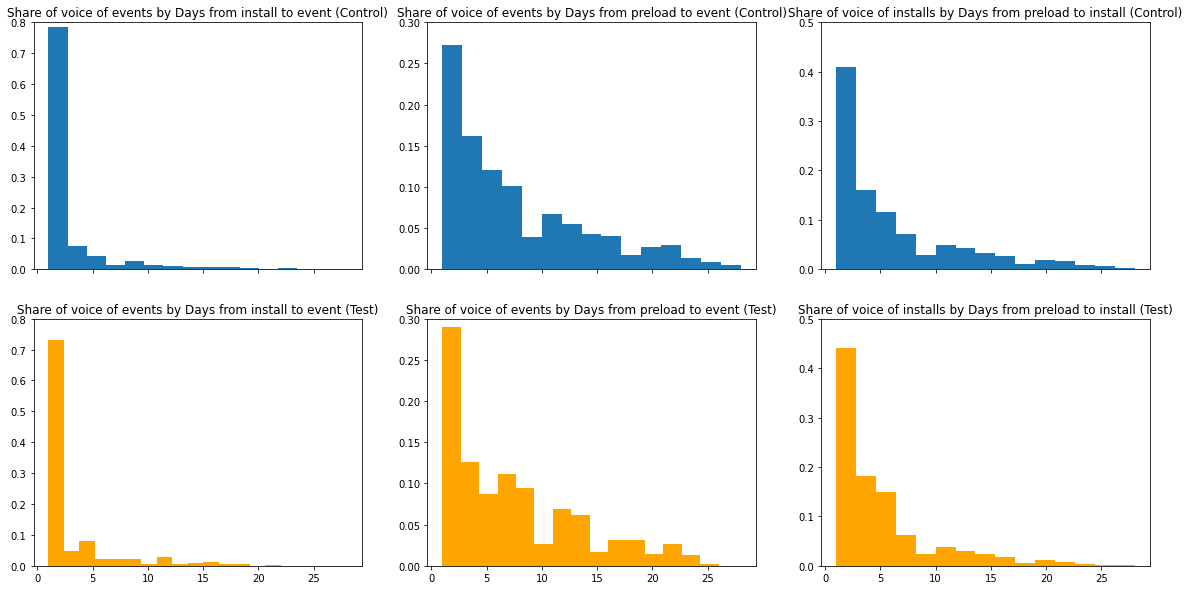

In [235]:
df_merged['preload_to_install'] = np.ceil((df_merged['timestamp_install'] - df_merged['timestamp_preload']).dt.total_seconds()/86400.)
df_merged['install_to_event'] = np.ceil((df_merged['timestamp_event'] - df_merged['timestamp_install']).dt.total_seconds()/86400.)
df_merged['preload_to_event'] = np.ceil((df_merged['timestamp_event'] - df_merged['timestamp_preload']).dt.total_seconds()/86400.)

fig, ax = plt.subplots(2,3, figsize = (20,10), sharex = True)

install_to_event_control = df_merged.loc[(~df_merged['install_to_event'].isna()) & (df_merged.test_audience == 'control'), 'install_to_event']
install_to_event_test = df_merged.loc[(~df_merged['install_to_event'].isna()) & (df_merged.test_audience == 'test'), 'install_to_event']
preload_to_event_control = df_merged.loc[(~df_merged['preload_to_event'].isna()) & (df_merged.test_audience == 'control'), 'preload_to_event']
preload_to_event_test = df_merged.loc[(~df_merged['preload_to_event'].isna()) & (df_merged.test_audience == 'test'), 'preload_to_event']
preload_to_install_control = df_merged.loc[(~df_merged['preload_to_install'].isna()) & (df_merged.test_audience == 'control'), 'preload_to_install']
preload_to_install_test = df_merged.loc[(~df_merged['preload_to_install'].isna()) & (df_merged.test_audience == 'test'), 'preload_to_install']
bins = 15

ax[0,0].hist(install_to_event_control, bins = bins, weights=np.ones(len(install_to_event_control)) / len(install_to_event_control))
ax[0,0].set_title('Share of voice of events by Days from install to event (Control)')
ax[0,0].set_ylim(0,.8)
ax[1,0].hist(install_to_event_test, bins = bins, color = 'orange', weights=np.ones(len(install_to_event_test)) / len(install_to_event_test))
ax[1,0].set_title('Share of voice of events by Days from install to event (Test)')
ax[1,0].set_ylim(0,.8)
ax[0,1].hist(preload_to_event_control, bins = bins, weights=np.ones(len(preload_to_event_control)) / len(preload_to_event_control))
ax[0,1].set_title('Share of voice of events by Days from preload to event (Control)')
ax[0,1].set_ylim(0,.3)
ax[1,1].hist(preload_to_event_test, bins = bins, color = 'orange', weights=np.ones(len(preload_to_event_test)) / len(preload_to_event_test))
ax[1,1].set_title('Share of voice of events by Days from preload to event (Test)')
ax[1,1].set_ylim(0,.3)
ax[0,2].hist(preload_to_install_control, bins = bins, weights=np.ones(len(preload_to_install_control)) / len(preload_to_install_control))
ax[0,2].set_title('Share of voice of installs by Days from preload to install (Control)')
ax[0,2].set_ylim(0,.5)
ax[1,2].hist(preload_to_install_test, bins = bins, color = 'orange', weights=np.ones(len(preload_to_install_test)) / len(preload_to_install_test))
ax[1,2].set_title('Share of voice of installs by Days from preload to install (Test)')
ax[1,2].set_ylim(0,.5)

In [236]:
df_audience = df_by_device.pivot_table(values = ['timestamp_install','timestamp_event'], index = 'test_audience', aggfunc = lambda x:(x>0).sum())
df_audience.columns = ['u_events','u_installs']
df_preload_audience = df_preload_filtered.pivot_table(values = 'aaid', index = ['test_audience'], aggfunc = pd.Series.nunique)
df_preload_audience.columns = ['u_preloads']
final_pivot = df_preload_audience.join(df_audience,how = 'left')
final_pivot['u_install_rate'] = final_pivot['u_installs']/final_pivot['u_preloads']
final_pivot['u_preload_event_rate'] = final_pivot['u_events']/final_pivot['u_preloads']
final_pivot['u_install_event_rate'] = final_pivot['u_events']/final_pivot['u_installs']
final_pivot

u_preloads  u_events  u_installs  u_install_rate  \
test_audience                                                     
control            903416      2776       18150        0.020090   
test               159924       529       20290        0.126873   

               u_preload_event_rate  u_install_event_rate  
test_audience                                              
control                    0.003073              0.152948  
test                       0.003308              0.026072

In [237]:
# need to pivot by device in order to count only unique installs/events
# simple "count" will double-count installs and events, but we will dedupe for unique installs/events next cell

df_by_device_site_type = df_merged.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['test_audience','notification','preload_type','aaid'], aggfunc = 'count')
df_by_device_site_type

timestamp_event  \
test_audience notification preload_type aaid                                                    
control       False        AppSelect    001f393e-7206-41ec-813d-34861f94dcc9                0   
                                        004eca9b-37a7-4ebf-9ebd-02bc4d40ea93                0   
                                        00a3b57e-9bdd-4e63-ae54-f162a0ecae5d                7   
                                        00d3462d-4d13-4ce7-8d1e-3340d7264dec                2   
                                        00eb2b4d-32b5-4493-9834-717e1957b5d8                0   
...                                                                                       ...   
test          True         Silent       ffa66dbf-ed0f-434b-ad98-bd8eec01bb29                0   
                                        ffb7be41-5250-4b5c-a130-b98af4347c59                0   
                                        ffbda22c-c346-4526-9d3f-6991be548ce6                0   
                                        ffd7492f-79a7-4f80-9de4-6297426fbff8                0   
                                        ffe71345-e2d5-44cc-9702-8b85fbc24a5b                0   

                                                                              timestamp_install  
test_audience notification preload_type aaid                                                     
control       False        AppSelect    001f393e-7206-41ec-813d-34861f94dcc9                  6  
                                        004eca9b-37a7-4ebf-9ebd-02bc4d40ea93                  7  
                                        00a3b57e-9bdd-4e63-ae54-f162a0ecae5d                  7  
                                        00d3462d-4d13-4ce7-8d1e-3340d7264dec                  2  
                                        00eb2b4d-32b5-4493-9834-717e1957b5d8                  2  
...                                                                                         ...  
test          True         Silent       ffa66dbf-ed0f-434b-ad98-bd8eec01bb29                  1  
                                        ffb7be41-5250-4b5c-a130-b98af4347c59                  1  
                                        ffbda22c-c346-4526-9d3f-6991be548ce6                  1  
                                        ffd7492f-79a7-4f80-9de4-6297426fbff8                  1  
                                        ffe71345-e2d5-44cc-9702-8b85fbc24a5b                  1  

[38526 rows x 2 columns]

In [238]:
df_audience_site_type = df_by_device_site_type.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['test_audience','preload_type','notification'], aggfunc = lambda x:(x>0).sum())
df_audience_site_type.columns = ['u_events','u_installs']
df_preload_audience_site_type = df_preload_filtered.pivot_table(values = 'aaid', index = ['test_audience','preload_type','notification'], aggfunc = pd.Series.nunique)
df_preload_audience_site_type.columns = ['u_preloads']
final_pivot_site_type = df_preload_audience_site_type.join(df_audience_site_type,how = 'left')
final_pivot_site_type['u_install_rate'] = final_pivot_site_type['u_installs']/final_pivot_site_type['u_preloads']
final_pivot_site_type['u_preload_event_rate'] = final_pivot_site_type['u_events']/final_pivot_site_type['u_preloads']
final_pivot_site_type['u_install_event_rate'] = final_pivot_site_type['u_events']/final_pivot_site_type['u_installs']
final_pivot_site_type

u_preloads  u_events  u_installs  \
test_audience preload_type notification                                     
control       AppSelect    False              63158     128.0      1364.0   
              Silent       False             843174    2652.0     16872.0   
test          AppSelect    False              31670     118.0      4665.0   
                           True                   2       NaN         NaN   
              Silent       False             105098     350.0     13188.0   
                           True               23159      61.0      2437.0   

                                         u_install_rate  u_preload_event_rate  \
test_audience preload_type notification                                         
control       AppSelect    False               0.021597              0.002027   
              Silent       False               0.020010              0.003145   
test          AppSelect    False               0.147300              0.003726   
                           True                     NaN                   NaN   
              Silent       False               0.125483              0.003330   
                           True                0.105229              0.002634   

                                         u_install_event_rate  
test_audience preload_type notification                        
control       AppSelect    False                     0.093842  
              Silent       False                     0.157183  
test          AppSelect    False                     0.025295  
                           True                           NaN  
              Silent       False                     0.026539  
                           True                      0.025031

In [239]:
df_by_device_site = df_merged.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['test_audience','site_name','site_id','aaid'], aggfunc = 'count')
df_by_device_site

timestamp_event  \
test_audience site_name                                          site_id aaid                                                    
control       DT - ATT - US - Ignite - Alcatel - AXEL - 5004R... 12111   039bcfa7-5064-4daf-a898-851f66a2959d                0   
                                                                         0fcff8fb-29c8-4a69-ab78-dc6d4da80524                0   
                                                                         1e0db548-75ae-44fb-807c-2de485315be8                0   
                                                                         33297932-e057-42e7-a28a-e1a2cca713d2                0   
                                                                         33668b5a-060c-4845-9818-eeafdd664043                0   
...                                                                                                                        ...   
test          DT - US Cellular - US - Ignite - Samsung Tab E8... 11229   aeb1101d-d1bd-45b6-a726-d0bb7d384b5e                0   
                                                                         e265acfa-fa5e-4733-b4b7-803957bcbd62                0   
              DT - US Cellular - US - Ignite - Samsung- A20 -... 11481   1ec06ef9-2b67-4a8d-b957-ca0b7c2fb7c3                0   
                                                                         aabc7d58-dad5-4a49-9bab-e0e9299c72d1                0   
                                                                         d9b01ba6-7617-4f4f-9eaf-17ecd2d2a049                0   

                                                                                                               timestamp_install  
test_audience site_name                                          site_id aaid                                                     
control       DT - ATT - US - Ignite - Alcatel - AXEL - 5004R... 12111   039bcfa7-5064-4daf-a898-851f66a2959d                  5  
                                                                         0fcff8fb-29c8-4a69-ab78-dc6d4da80524                  3  
                                                                         1e0db548-75ae-44fb-807c-2de485315be8                  1  
                                                                         33297932-e057-42e7-a28a-e1a2cca713d2                  2  
                                                                         33668b5a-060c-4845-9818-eeafdd664043                  2  
...                                                                                                                          ...  
test          DT - US Cellular - US - Ignite - Samsung Tab E8... 11229   aeb1101d-d1bd-45b6-a726-d0bb7d384b5e                  1  
                                                                         e265acfa-fa5e-4733-b4b7-803957bcbd62                  1  
              DT - US Cellular - US - Ignite - Samsung- A20 -... 11481   1ec06ef9-2b67-4a8d-b957-ca0b7c2fb7c3                  1  
                                                                         aabc7d58-dad5-4a49-9bab-e0e9299c72d1                  1  
                                                                         d9b01ba6-7617-4f4f-9eaf-17ecd2d2a049                  1  

[38528 rows x 2 columns]

In [240]:
df_audience_site = df_by_device_site.pivot_table(values = ['timestamp_install','timestamp_event'], index = ['site_name','site_id','test_audience'], aggfunc = lambda x:(x>0).sum())
df_audience_site.columns = ['u_events','u_installs']
df_preload_audience_site = df_preload_filtered.pivot_table(values = 'aaid', index = ['site_id','site_name','test_audience'], aggfunc = pd.Series.nunique)
df_preload_audience_site.columns = ['u_preloads']
final_pivot_site = df_preload_audience_site.join(df_audience_site,how = 'left')
final_pivot_site['u_install_rate'] = final_pivot_site['u_installs']/final_pivot_site['u_preloads']
final_pivot_site['u_event_rate'] = final_pivot_site['u_events']/final_pivot_site['u_preloads']
final_pivot_site.to_csv('~/Downloads/Lyft_incrementality_bySite.csv')

# Calculating Results
Let $p_T$ be the probability of an event given the user is shown a DT preload (test group).
Let $p_C$ be the probability of an event given the user is eligible, but not shown a DT preload (control group).  
$H_0: p_T = p_C $  
$H_A: p_T > p_C $    
  
We will use a two-proportion t-test since the samples are large enough to offset for the underlying binomial distribution. We will use an alpha (false positive threshold) of 10%:  
$\hat p_T = \frac{\text{unique events}}{\text{unique App preloads}}$  
$\hat p_C = \frac{\text{unique events}}{\text{unique eligible preloads}}$   
$SE_{\hat p} = \sqrt{\hat p (1-\hat p)(\frac{1}{n_t}+\frac{1}{n_c})}$  
$t = \frac{\hat p_T - \hat p_C}{SE_{\hat p}}$

In [241]:
n_t = final_pivot.loc[final_pivot.index == 'test','u_preloads'].sum()
n_c = final_pivot.loc[final_pivot.index == 'control','u_preloads'].sum()
e_t = final_pivot.loc[final_pivot.index == 'test','u_events'].sum()
e_c = final_pivot.loc[final_pivot.index == 'control','u_events'].sum()

phat_t = e_t/n_t
phat_c = e_c/n_c
phat = (e_t+e_c)/(n_t+n_c)
degrees_freedom = (n_t-1)+(n_c-1)
standard_error = np.sqrt(phat * (1-phat) * ((1/n_t)+(1/n_c)))
t = (phat_t - phat_c)/standard_error
p = 1-stats.t.cdf(t,df=degrees_freedom)
result = 'fail' if p > .1 else 'succeed'
print('test sample event rate:',round(100*float(phat_t),3),'%')
print('control sample event rate:',round(100*float(phat_c),3),'%')
print('pooled (total) sample event rate:',round(100*float(phat),3),'%')
print('degrees of freedom:',degrees_freedom)
print('standard error:',round(standard_error,5))
print('t statistic:',t)
print('p-value:',p)
print('results:',result,'to reject null hypothesis')

test sample event rate: 0.331 %
control sample event rate: 0.307 %
pooled (total) sample event rate: 0.311 %
degrees of freedom: 1063338
standard error: 0.00015
t statistic: 1.5564391486176072
p-value: 0.059801999832105324
results: succeed to reject null hypothesis
